In [53]:
# Librerías estándar
import pandas as pd
import numpy as np

# Visualización
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib import style
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib as mpl
import plotly.graph_objects as go
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

# Modelos y preprocesamiento
# ==============================================================================
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.metrics import rand_score
from sklearn.metrics import completeness_score
from sklearn.model_selection import KFold


# Cargar y Preprocesar los Datos

In [2]:
# Cargar datos
df_fraude = pd.read_csv('fraud_test.csv', sep=",")

In [4]:
#Separar la fecha y la hora en columnas distintas

# Convertir la columna 'trans_date_trans_time' a tipo datetime
df_fraude['trans_date_trans_time'] = pd.to_datetime(df_fraude['trans_date_trans_time'])

# Crear nuevas columnas para la fecha y la hora
df_fraude['fecha'] = df_fraude['trans_date_trans_time'].dt.date
df_fraude['hora'] = df_fraude['trans_date_trans_time'].dt.time


C:\Users\bever\AppData\Local\Temp\ipykernel_6512\3998650541.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_fraude['trans_date_trans_time'] = pd.to_datetime(df_fraude['trans_date_trans_time'])


In [5]:
#Separar la fecha de nacimiento en nuevas columnas:
# Asegúrate de que 'dob' esté en formato datetime
df_fraude['dob'] = pd.to_datetime(df_fraude['dob'], dayfirst=True)

# Crear nuevas columnas para el año, mes y día de nacimiento
df_fraude['anio_nacimiento'] = df_fraude['dob'].dt.year
df_fraude['mes_nacimiento'] = df_fraude['dob'].dt.month
df_fraude['dia_nacimiento'] = df_fraude['dob'].dt.day

In [6]:
#Calcular la Edad:

# Definir la función calcular_edad
def calcular_edad(fecha_nacimiento, fecha_actual):
    edad = fecha_actual.year - fecha_nacimiento.year
    if fecha_actual.month < fecha_nacimiento.month or (fecha_actual.month == fecha_nacimiento.month and fecha_actual.day < fecha_nacimiento.day):
        edad -= 1
    return edad

# Convertir la columna 'trans_date_trans_time' a tipo datetime
df_fraude['trans_date_trans_time'] = pd.to_datetime(df_fraude['trans_date_trans_time'])

# Crear nuevas columnas para la fecha y la hora
df_fraude['fecha'] = df_fraude['trans_date_trans_time'].dt.date
df_fraude['hora'] = df_fraude['trans_date_trans_time'].dt.time

# Convertir la columna 'dob' a tipo datetime, especificando el formato
df_fraude['dob'] = pd.to_datetime(df_fraude['dob'], dayfirst=True)

# Obtener la fecha actual o usar una columna específica
fecha_actual = pd.to_datetime('today').date()

# Calcular la edad basado en la fecha de la transacción o fecha actual
df_fraude['edad'] = df_fraude['dob'].apply(lambda dob: calcular_edad(pd.to_datetime(dob).date(), fecha_actual))

In [7]:
df_fraude.describe()

Unnamed: 0          trans_date_trans_time        cc_num  \
count  555719.000000                         555719  5.557190e+05   
mean   277859.000000  2020-10-02 01:53:55.673389056  4.178387e+17   
min         0.000000            2020-06-21 12:14:00  6.041621e+10   
25%    138929.500000            2020-08-09 06:10:00  1.800430e+14   
50%    277859.000000            2020-10-03 00:59:00  3.521420e+15   
75%    416788.500000            2020-12-01 03:02:30  4.635330e+15   
max    555718.000000            2020-12-31 23:59:00  4.992350e+18   
std    160422.401459                            NaN  1.309837e+18   

                 amt            zip            lat           long  \
count  555719.000000  555719.000000  555719.000000  555719.000000   
mean       69.392810   48842.628015      38.543253     -90.231325   
min         1.000000    1257.000000      20.027100    -165.672300   
25%         9.630000   26292.000000      34.668900     -96.798000   
50%        47.290000   48174.000000      39.371600     -87.476900   
75%        83.010000   72011.000000      41.894800     -80.175200   
max     22768.110000   99921.000000      65.689900     -67.950300   
std       156.745941   26855.283328       5.061336      13.721780   

           city_pop                            dob     unix_time  \
count  5.557190e+05                         555719  5.557190e+05   
mean   8.822189e+04  1973-11-11 16:30:05.937173264  1.380679e+09   
min    2.300000e+01            1924-10-30 00:00:00  1.371817e+09   
25%    7.410000e+02            1962-09-27 00:00:00  1.376029e+09   
50%    2.408000e+03            1975-11-30 00:00:00  1.380762e+09   
75%    1.968500e+04            1987-04-23 00:00:00  1.385867e+09   
max    2.906700e+06            2005-01-29 00:00:00  1.388534e+09   
std    3.003909e+05                            NaN  5.201104e+06   

           merch_lat     merch_long       is_fraud  category_encoded  \
count  555719.000000  555719.000000  555719.000000     555719.000000   
mean       38.542798     -90.231380       0.003860          6.237059   
min        19.027422    -166.671575       0.000000          0.000000   
25%        34.755302     -96.905129       0.000000          3.000000   
50%        39.376593     -87.445204       0.000000          6.000000   
75%        41.954163     -80.264637       0.000000         10.000000   
max        66.679297     -66.952026       1.000000         13.000000   
std         5.095829      13.733071       0.062008          3.912874   

       state_encoded  anio_nacimiento  mes_nacimiento  dia_nacimiento  \
count  555719.000000    555719.000000   555719.000000   555719.000000   
mean       25.771627      1973.363763        6.527894       15.673367   
min         0.000000      1924.000000        1.000000        1.000000   
25%        14.000000      1962.000000        4.000000        8.000000   
50%        26.000000      1975.000000        7.000000       15.000000   
75%        37.000000      1987.000000        9.000000       23.000000   
max        49.000000      2005.000000       12.000000       31.000000   
std        14.116718        17.418528        3.399485        8.888683   

                edad  
count  555719.000000  
mean       50.269354  
min        19.000000  
25%        37.000000  
50%        48.000000  
75%        61.000000  
max        99.000000  
std        17.430994

## Analisis


In [8]:
# Seleccionar columnas numéricas para el análisis
features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'edad', 'zip']
X = df_fraude[features]

# Normalización de las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Tomar una muestra aleatoria
sample_size = 10000
df_sample = df_fraude.sample(n=sample_size, random_state=42)

# Seleccionar las mismas características en la muestra
X_sample = df_sample[features]

# Normalizar las características de la muestra
X_sample_scaled = scaler.fit_transform(X_sample)

In [10]:
# Confirmar las formas de los conjuntos de datos
print(f'Forma de X_scaled: {X_scaled.shape}')
print(f'Forma de X_sample_scaled: {X_sample_scaled.shape}')

Forma de X_scaled: (555719, 8)
Forma de X_sample_scaled: (10000, 8)


In [11]:
# Evaluar diferentes números de componentes
n_components_range = range(2, 11)  # Ajusta el rango según sea necesario
silhouette_scores = [] # lista para almacenar los valores del coeficiente de silueta para cada número de componentes.

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    clusters = gmm.fit_predict(X_sample_scaled)
    
    # Solo calcular el Silhouette Score si hay más de 1 cluster
    if len(np.unique(clusters)) > 1:
        sil_score = silhouette_score(X_sample_scaled, clusters)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(np.nan)  # No calculable

In [12]:
# Encontrar el número de componentes con el máximo Silhouette Score
max_score = np.nanmax(silhouette_scores)  # Usar np.nanmax para ignorar NaN
best_n_components = n_components_range[np.nanargmax(silhouette_scores)]  # Usar np.nanargmax para ignorar NaN

print(f'Número óptimo de Componentes: {best_n_components}')
print(f'Máximo Silhouette Score: {max_score:.4f}')


Número óptimo de Componentes: 3
Máximo Silhouette Score: 0.1252


## Graficar análisis Silhouette Score

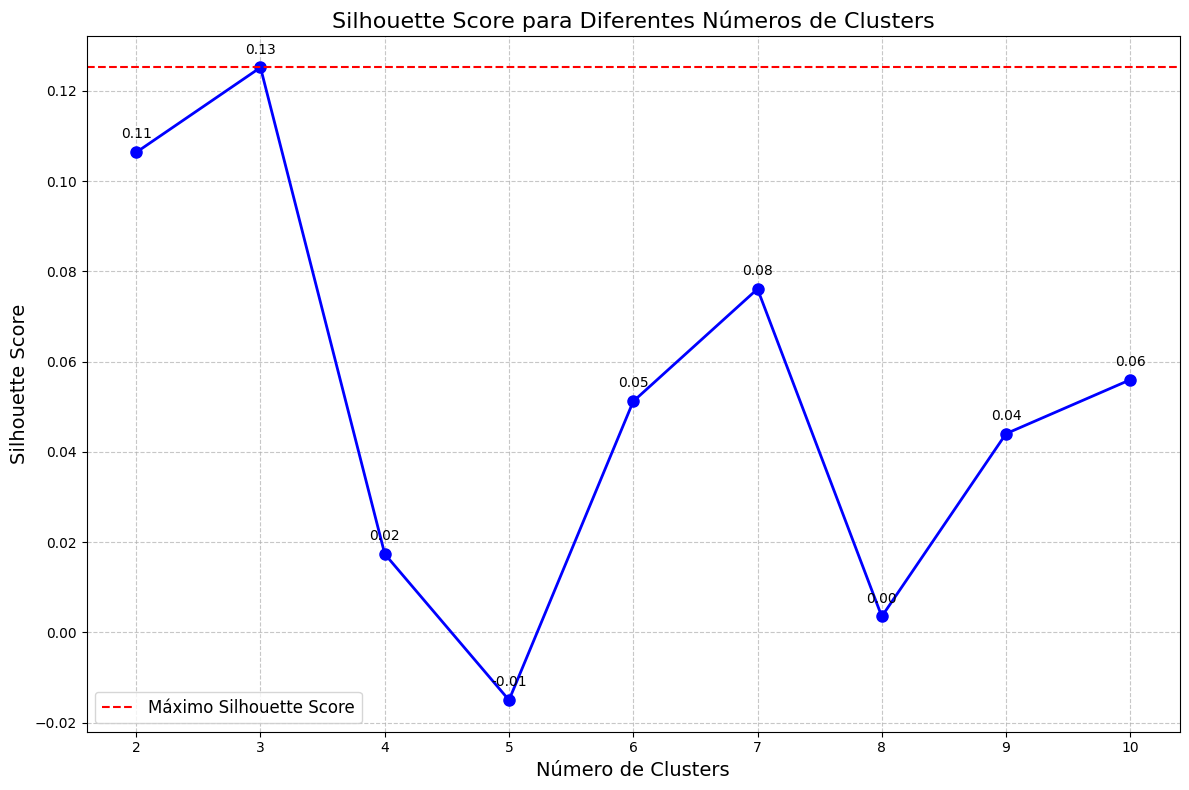

In [13]:
plt.figure(figsize=(12, 8))  # Ajusta el tamaño de la figura

plt.plot(n_components_range, silhouette_scores, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Agregar una línea horizontal de referencia (si es necesario)
plt.axhline(y=max(silhouette_scores), color='r', linestyle='--', label='Máximo Silhouette Score')

# Mejorar etiquetas y título
plt.xlabel('Número de Clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.title('Silhouette Score para Diferentes Números de Clusters', fontsize=16)

# Añadir leyenda
plt.legend(fontsize=12)

# Añadir rejilla
plt.grid(True, linestyle='--', alpha=0.7)

# Anotaciones para puntos específicos
for i, score in enumerate(silhouette_scores):
    plt.annotate(f'{score:.2f}', (n_components_range[i], score), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

# Ajustar márgenes y espaciado
plt.tight_layout()

plt.show()


Número de Componentes (3): Esto indica que el modelo GMM con 3 componentes parece ser la mejor opción según el coeficiente de silueta. Esto puede sugerir que los datos se agrupan mejor en 3 clusters en comparación con otros números de componentes evaluados.

Valor Bajo del Silhouette Score: Un valor de 0.1252 es relativamente bajo, lo que sugiere que la calidad de los clusters no es muy alta. En general, los valores del coeficiente de silueta varían entre -1 y 1.

### Análisis con 3 componentes

In [14]:
# Número óptimo de componentes
optimal_n_components = 3

In [15]:
# Ajustar y predecir con GMM
gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm_optimal.fit(X_sample_scaled)
clusters = gmm_optimal.predict(X_sample_scaled)


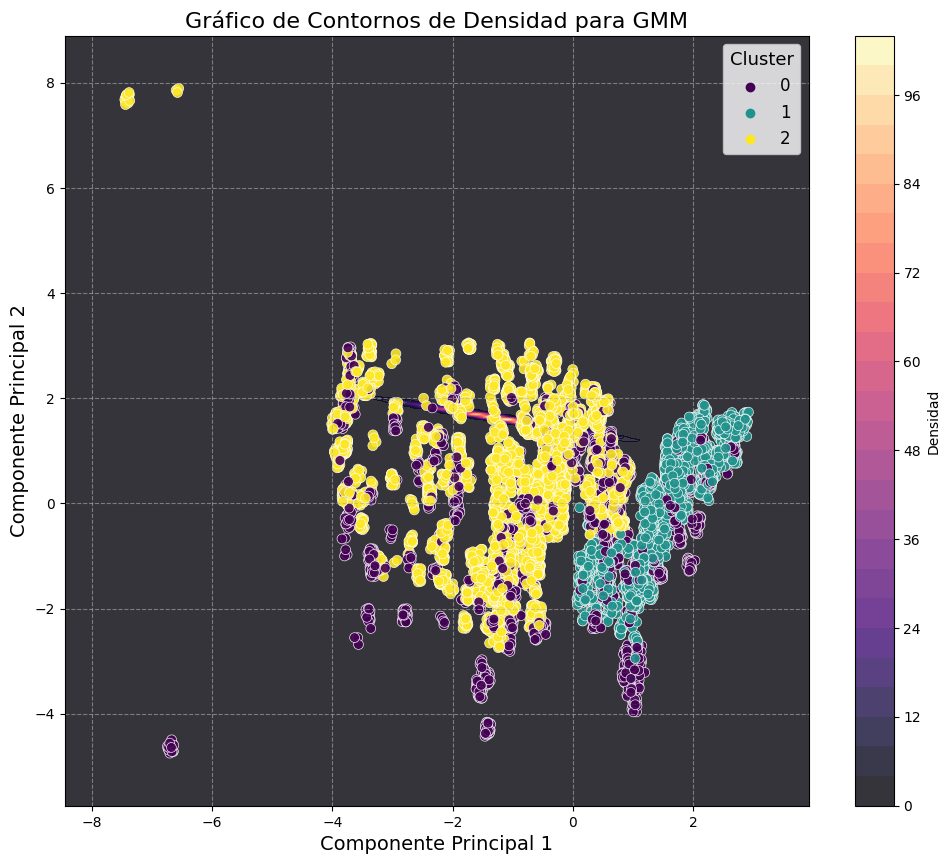

In [16]:
# PCA para reducción a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

# Crear una grilla para evaluar la densidad
x = np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 300)
y = np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 300)
Xgrid, Ygrid = np.meshgrid(x, y)
XYgrid = np.array([Xgrid.ravel(), Ygrid.ravel()]).T

# Evaluar la densidad en cada punto de la grilla usando el modelo GMM
densidad = np.exp(gmm_optimal.score_samples(pca.inverse_transform(XYgrid)))
densidad = densidad.reshape(Xgrid.shape)

# Graficar los puntos y los contornos de densidad en 2D
plt.figure(figsize=(12, 10))

# Gráfico de contornos de densidad
contour = plt.contourf(Xgrid, Ygrid, densidad, levels=30, cmap='magma', alpha=0.8)

# Gráfico de dispersión de los puntos
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=50, alpha=0.9, edgecolor='w', linewidth=0.5)

# Añadir la barra de color
plt.colorbar(contour, label='Densidad')

# Configuración de la visualización
plt.title('Gráfico de Contornos de Densidad para GMM', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize='13')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

El gráfico presenta tres clusters distintos (0, 1, 2), cada uno identificado por diferentes colores. Estos clusters representan regiones con alta densidad de puntos en el espacio de características reducido a dos dimensiones. La intensidad del color indica la densidad de puntos en cada región. Los colores más intensos en el gráfico (cerca de los contornos más densos) corresponden a áreas con mayor densidad de puntos, mientras que las áreas menos intensas representan baja densidad. Las líneas de contorno definen las regiones de igual densidad, proporcionando una visualización clara de cómo se distribuyen los datos en el espacio de componentes principales.

Es plausible que uno de los clusters (por ejemplo, el cluster 0) esté asociado con transacciones fraudulentas. Esto se basa en la suposición de que las transacciones fraudulentas tienden a formar clusters distintos debido a su naturaleza anómala. 

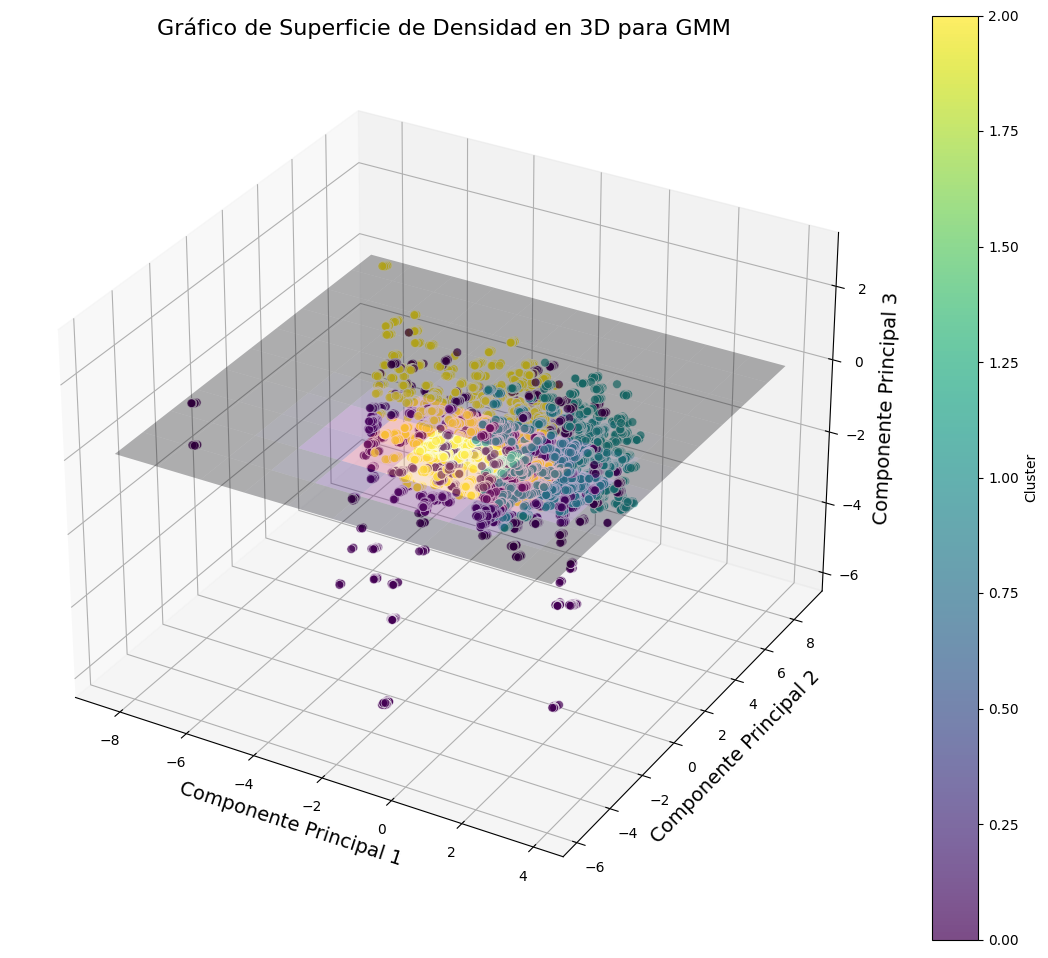

In [17]:
# PCA para reducción a 3D
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_sample_scaled)

# Crear una grilla para evaluar la densidad en 3D
x = np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 50)
y = np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 50)
z = np.linspace(X_pca[:, 2].min() - 1, X_pca[:, 2].max() + 1, 50)
Xgrid, Ygrid, Zgrid = np.meshgrid(x, y, z)
XYZgrid = np.array([Xgrid.ravel(), Ygrid.ravel(), Zgrid.ravel()]).T

# Evaluar la densidad en cada punto de la grilla usando el modelo GMM
densidad = np.exp(gmm_optimal.score_samples(pca.inverse_transform(XYZgrid)))
densidad = densidad.reshape(Xgrid.shape)

# Graficar los puntos y la superficie de densidad en 3D
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Gráfico de dispersión de los puntos
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', s=40, alpha=0.7, edgecolor='w', linewidth=0.5)

# Crear una superficie de densidad
ax.plot_surface(Xgrid[:, :, 0], Ygrid[:, :, 0], densidad[:, :, 0], rstride=5, cstride=5, alpha=0.3, cmap='magma')

# Configuración de la visualización
ax.set_title('Gráfico de Superficie de Densidad en 3D para GMM', fontsize=16)
ax.set_xlabel('Componente Principal 1', fontsize=14)
ax.set_ylabel('Componente Principal 2', fontsize=14)
ax.set_zlabel('Componente Principal 3', fontsize=14)
fig.colorbar(sc, ax=ax, label='Cluster')
plt.show()


El gráfico sugiere que los datos tienen una estructura compleja y no lineal. La presencia de múltiples clusters indica que los datos no se distribuyen de manera uniforme en el espacio. La separación entre los clusters parece ser bastante buena, lo que indica que el GMM ha logrado identificar grupos de datos relativamente homogéneos.

### Análisis con 7 componentes

Mejor número de clusters según el gráfico: El punto más alto en la gráfica suele indicar el número óptimo de clusters. En este caso, parece que el modelo con 7 componentes obtiene el valor más alto de Silhouette Score, sugiriendo que esta podría ser la configuración ideal para nuestros datos.

In [18]:
# Ajustar el modelo GMM con 7 clusters
optimal_n_components = 7
gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm_optimal.fit(X_sample_scaled)
clusters = gmm_optimal.predict(X_sample_scaled)

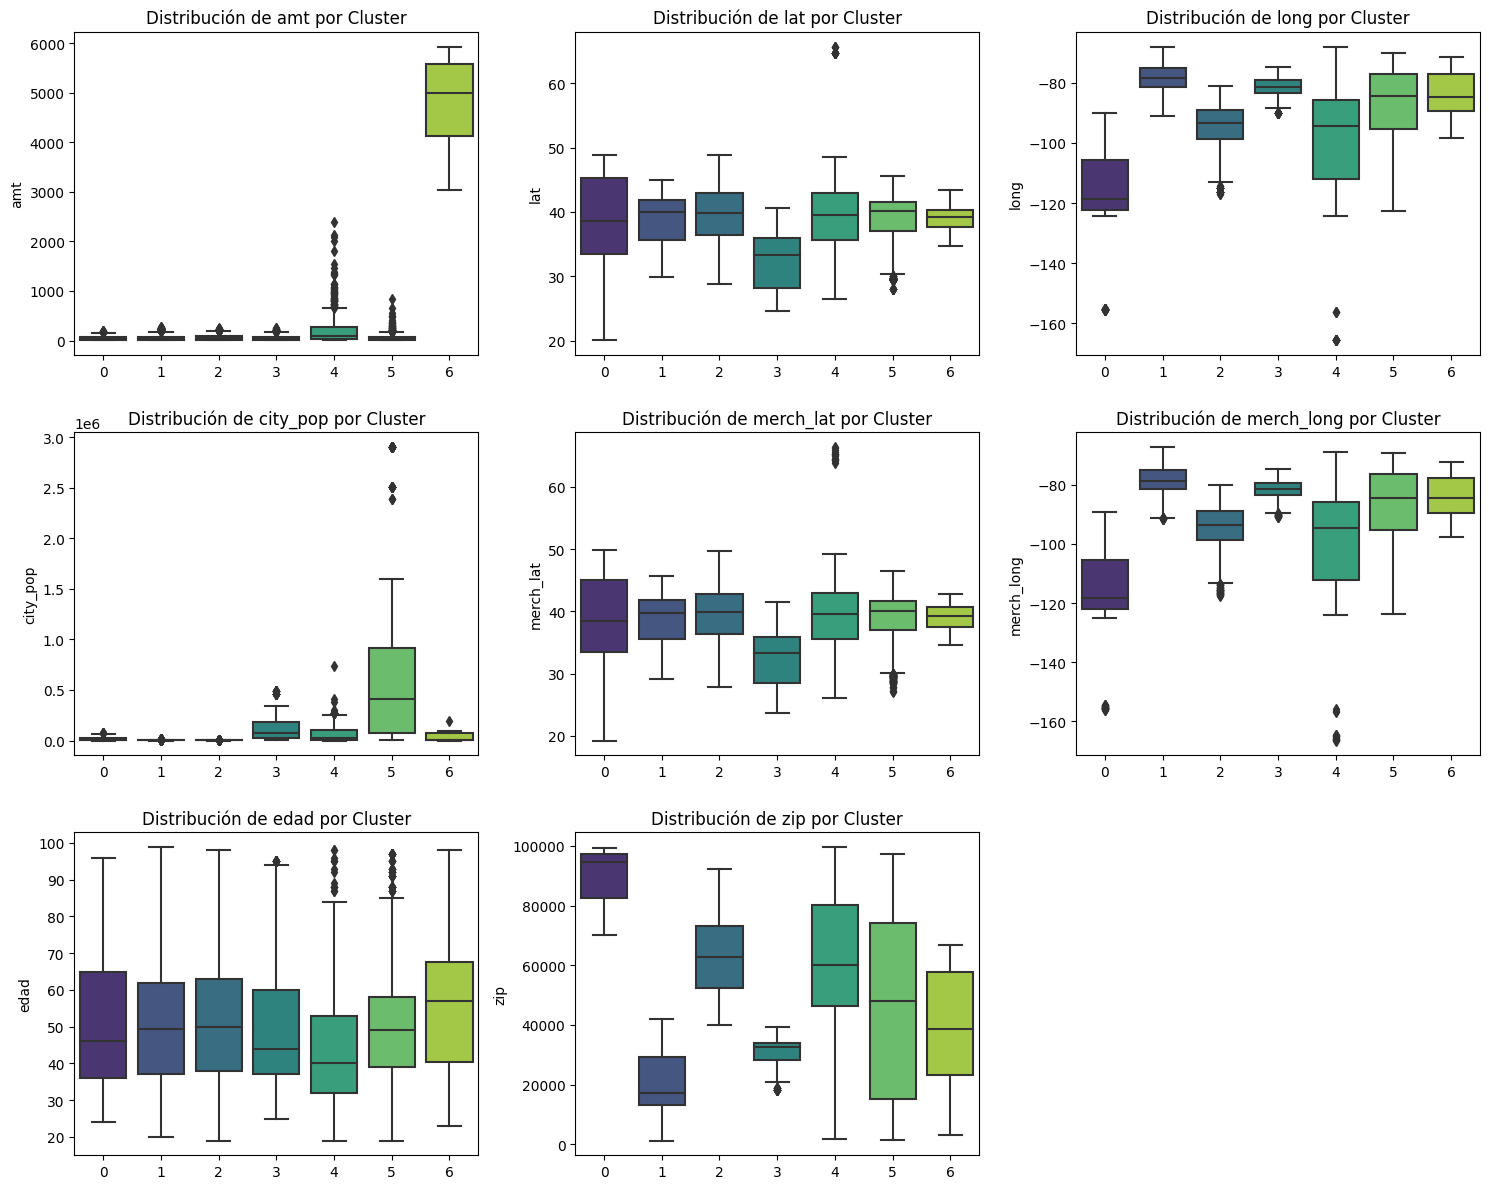

In [19]:
# Crear gráfico de distribución por cluster
plt.figure(figsize=(15, 12))
n_features = len(features)
n_cols = 3
n_rows = (n_features // n_cols) + (n_features % n_cols > 0)  # Calcula el número de filas necesarias

for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=clusters, y=X_sample[feature], palette='viridis')
    plt.title(f'Distribución de {feature} por Cluster')

plt.tight_layout()
plt.show()

c:\Users\bever\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bever\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\bever\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\bever\AppData\Local\Programs\Python\Python310\lib\site-p

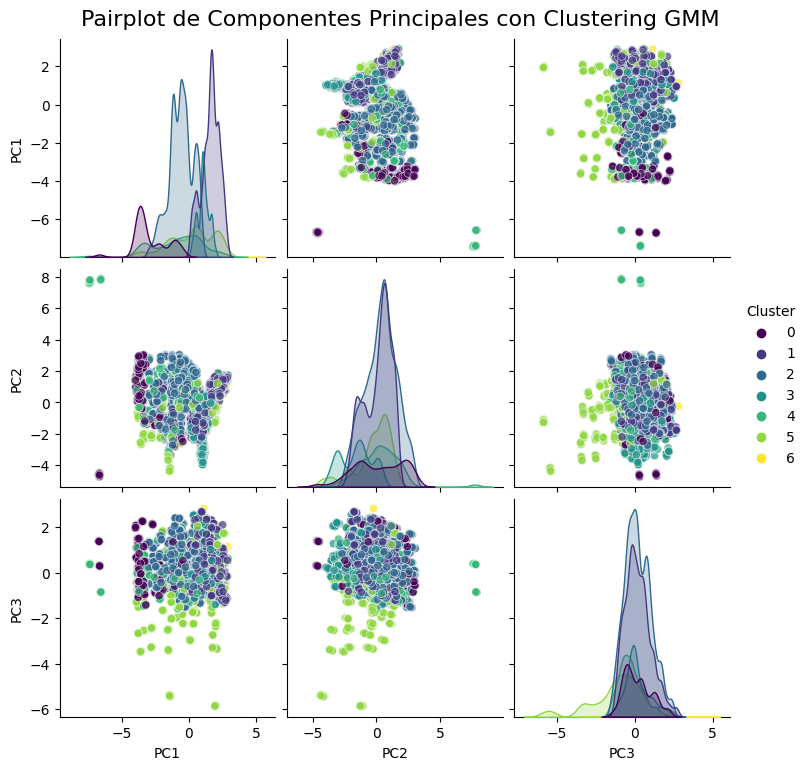

In [20]:
# Crear el DataFrame para la visualización
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['Cluster'] = clusters

# Crear el pairplot con Seaborn
sns.pairplot(df_pca, hue='Cluster', palette='viridis', markers='o', plot_kws={'alpha':0.7})
plt.suptitle('Pairplot de Componentes Principales con Clustering GMM', y=1.02, fontsize=16)
plt.show()


 La existencia de 7 clusters indica que los datos son heterogéneos y presentan una cierta variabilidad. Cada cluster captura una parte de esta variabilidad.Es evidente que existe una gran variabilidad en la distribución de las variables entre los diferentes clusters. Esto sugiere que el proceso de clustering ha logrado identificar grupos de datos con características distintivas. En varios de los gráficos se observan outliers, especialmente en las variables "amt" y "city_pop". Estos valores atípicos podrían influir en el análisis y deberían ser investigados más a fondo para determinar si son errores de datos o si representan casos verdaderamente excepcionales.

Análisis por Variable:

- amt: El monto parece variar considerablemente entre los clusters, con algunos clusters mostrando valores máximos mucho más altos que otros. Esto podría indicar diferencias en el gasto promedio o en el tipo de transacciones realizadas por los clientes en cada cluster.

- lat y long: La latitud y longitud también muestran diferencias significativas entre los clusters, lo que sugiere que los clientes en cada cluster están geográficamente concentrados en diferentes áreas.

- city_pop: La población de la ciudad parece estar relacionada con el monto gastado, con los clusters que tienen mayores valores de "city_pop" también mostrando valores más altos de "amt". Esto podría indicar que los clientes en ciudades más grandes tienden a gastar más.

- merch_lat y merch_long: La latitud y longitud del comerciante muestran patrones similares a los de la latitud y longitud del cliente, lo que sugiere que los clientes tienden a realizar compras en comercios cercanos a su ubicación.

- edad: La edad también muestra diferencias significativas entre los clusters, lo que indica que la edad es un factor importante para segmentar a los clientes.

- zip: El código postal muestra una gran variabilidad entre los clusters, lo que confirma la idea de que los clientes están geográficamente concentrados en diferentes áreas.

# Aplicar el Modelo GMM



### Entrenamiento del Modelo GMM

Para elegir el Número de Componentes se debe utilizar el criterio de información de Akaike (AIC) o el criterio bayesiano de información (BIC) para elegir el número óptimo de componentes.

In [21]:
# Evaluar diferentes números de componentes
n_components_range = range(2, 11)  # Ajusta el rango según sea necesario
aic_values = []
bic_values = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, n_init=1, max_iter=100, random_state=42)
    gmm.fit(X_sample_scaled)
    aic_values.append(gmm.aic(X_sample_scaled))
    bic_values.append(gmm.bic(X_sample_scaled))

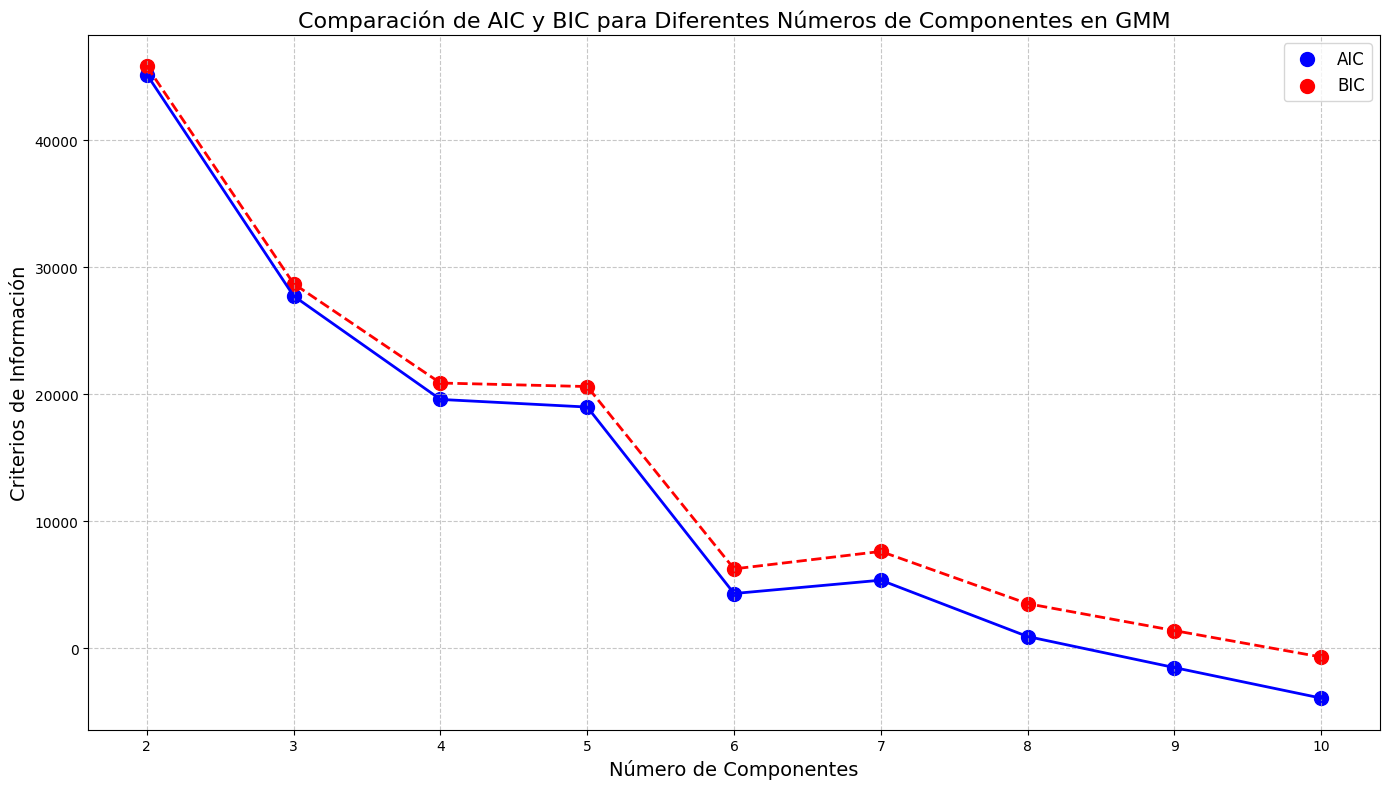

In [22]:
# Graficar dispersión con líneas para AIC y BIC
plt.figure(figsize=(14, 8))

plt.scatter(n_components_range, aic_values, color='blue', label='AIC', s=100)
plt.plot(n_components_range, aic_values, color='blue', linestyle='-', linewidth=2)

plt.scatter(n_components_range, bic_values, color='red', label='BIC', s=100)
plt.plot(n_components_range, bic_values, color='red', linestyle='--', linewidth=2)

plt.xlabel('Número de Componentes', fontsize=14)
plt.ylabel('Criterios de Información', fontsize=14)
plt.title('Comparación de AIC y BIC para Diferentes Números de Componentes en GMM', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
# Imprimir los valores AIC y BIC
for n_components, aic, bic in zip(n_components_range, aic_values, bic_values):
    print(f'Número de Componentes: {n_components}, AIC: {aic:.2f}, BIC: {bic:.2f}')

Número de Componentes: 2, AIC: 45173.34, BIC: 45815.06
Número de Componentes: 3, AIC: 27736.37, BIC: 28702.56
Número de Componentes: 4, AIC: 19592.97, BIC: 20883.62
Número de Componentes: 5, AIC: 18992.07, BIC: 20607.18
Número de Componentes: 6, AIC: 4308.83, BIC: 6248.41
Número de Componentes: 7, AIC: 5359.35, BIC: 7623.39
Número de Componentes: 8, AIC: 920.39, BIC: 3508.90
Número de Componentes: 9, AIC: -1524.54, BIC: 1388.44
Número de Componentes: 10, AIC: -3929.40, BIC: -691.96


Selección del número óptimo de componentes

AIC: El punto en el que el AIC alcanza un mínimo relativamente bajo, pero antes de que comience a aumentar significativamente, suele considerarse un buen candidato para el número óptimo de componentes. En este caso, parece ser alrededor de 5 o 6 componentes.


BIC: El BIC, al ser más conservador, tiende a seleccionar un número menor de componentes. En este gráfico, el mínimo del BIC podría estar alrededor de 4 o 5 componentes.

### Análisis basado en el BIC 

In [24]:
# Escalar los datos
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)


Determinar el número óptimo de componentes utilizando el BIC

In [25]:
# Ajusta el número de componentes basado en el BIC
bic_scores = []
n_components_range = range(1, 10)
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, n_init=1, random_state=42)
    gmm.fit(X_sample_scaled)
    bic_scores.append(gmm.bic(X_sample_scaled))

optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f'Optimal number of components based on BIC: {optimal_n_components}')


Optimal number of components based on BIC: 9


El análisis con el modelo Gaussian Mixture Model (GMM) realizado sobre un subconjunto de datos de transacciones con tarjetas de crédito, identificó un número óptimo de 9 componentes basado en el Criterio de Información Bayesiano (BIC). Este resultado sugiere que la distribución subyacente de los datos puede ser mejor modelada por 9 grupos gaussianos.

Una vez identificado el número óptimo de componentes, ajustar el modelo GMM con el número óptimo de componentes

In [26]:
gmm = GaussianMixture(n_components=optimal_n_components, n_init=1, random_state=42)
gmm.fit(X_sample_scaled)

# Obtener las etiquetas de cluster
labels = gmm.predict(X_sample_scaled)


In [27]:
df_clusters = pd.DataFrame(X_sample_scaled, columns=features)
df_clusters['Cluster'] = labels


In [28]:
from sklearn.utils import shuffle
X_sample_small = shuffle(X_sample_scaled, random_state=42)[:10000]
clusters_small = gmm.predict(X_sample_small)

sil_score_small = silhouette_score(X_sample_small, clusters_small)
print(f'Silhouette Score (small sample): {sil_score_small:.3f}')


Silhouette Score (small sample): 0.044


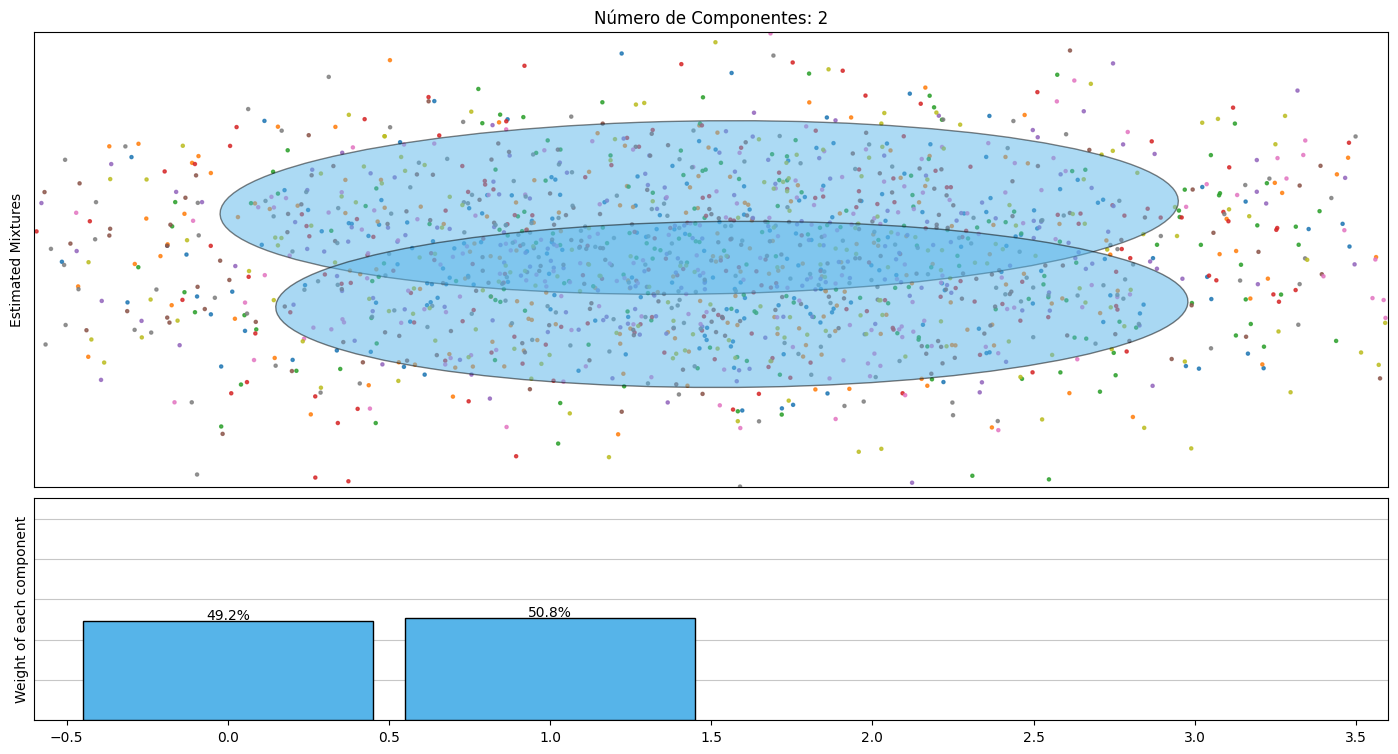

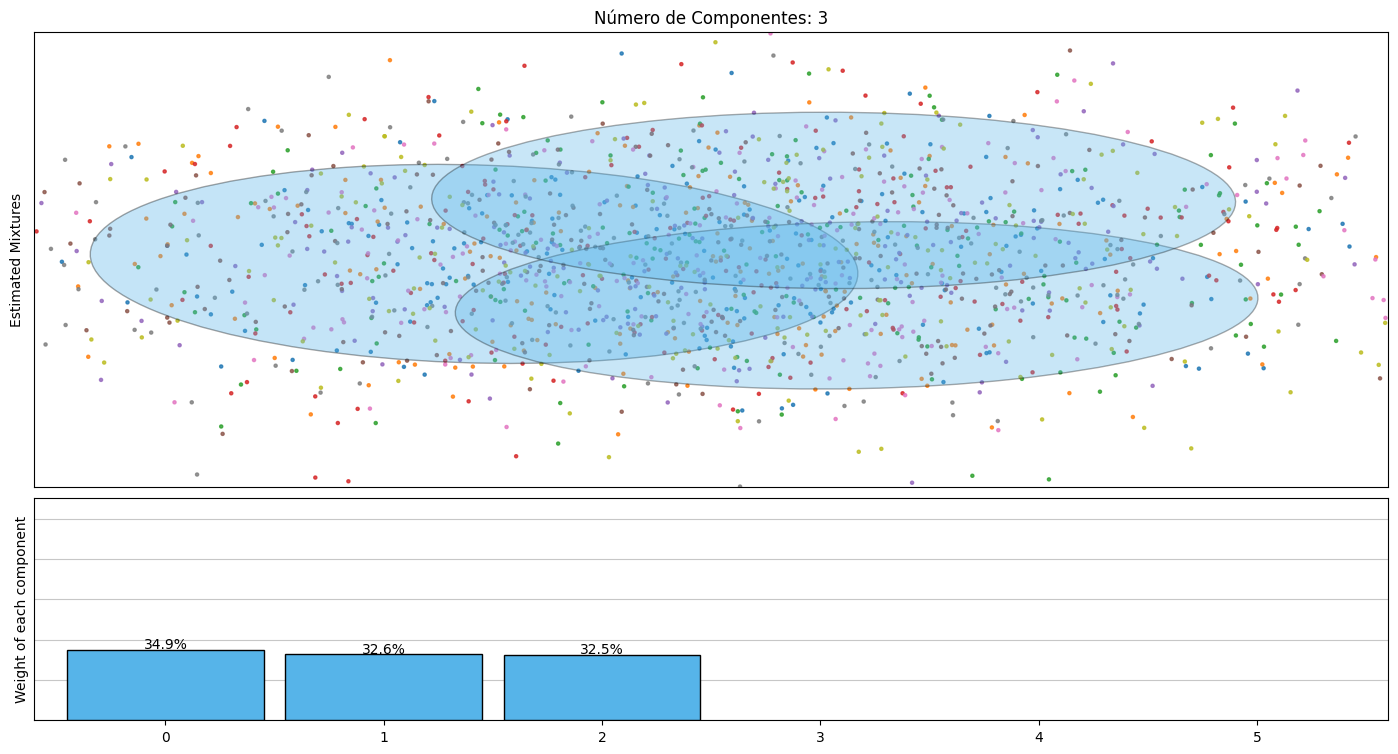

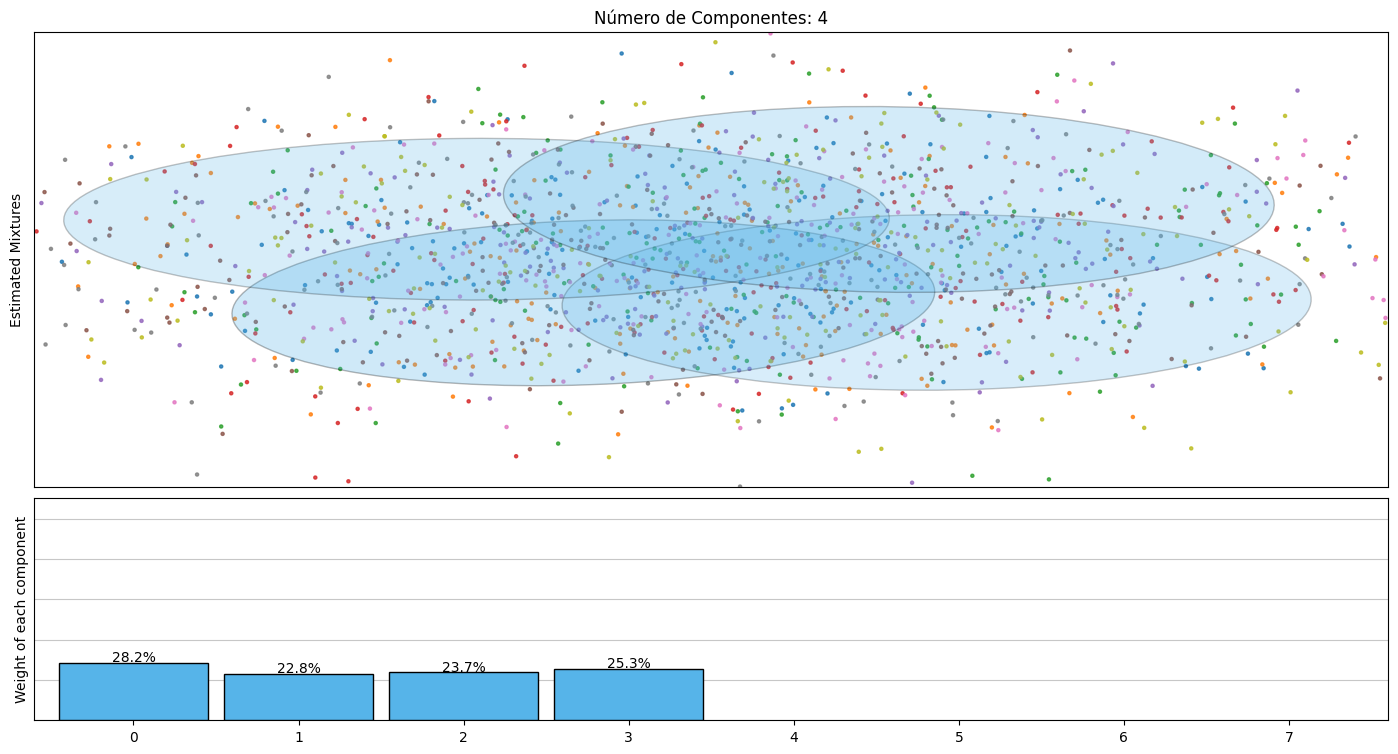

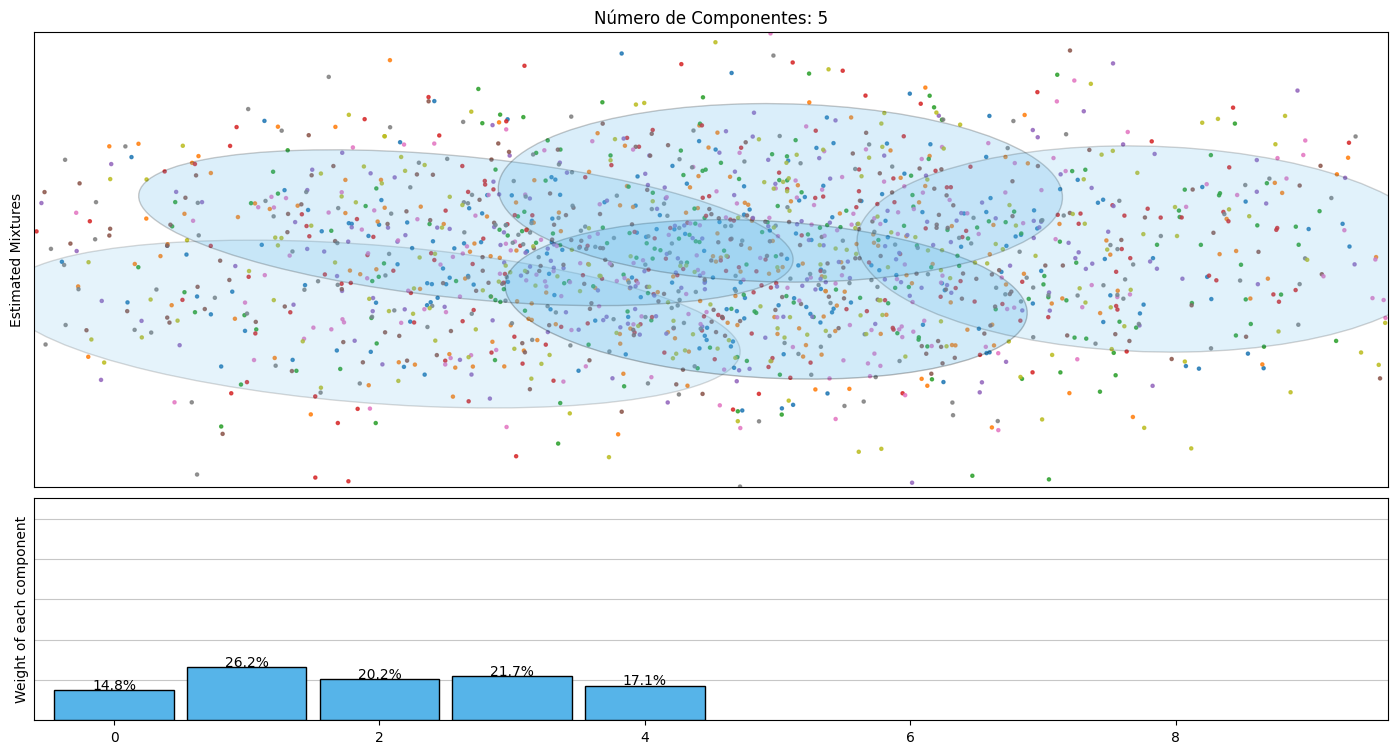

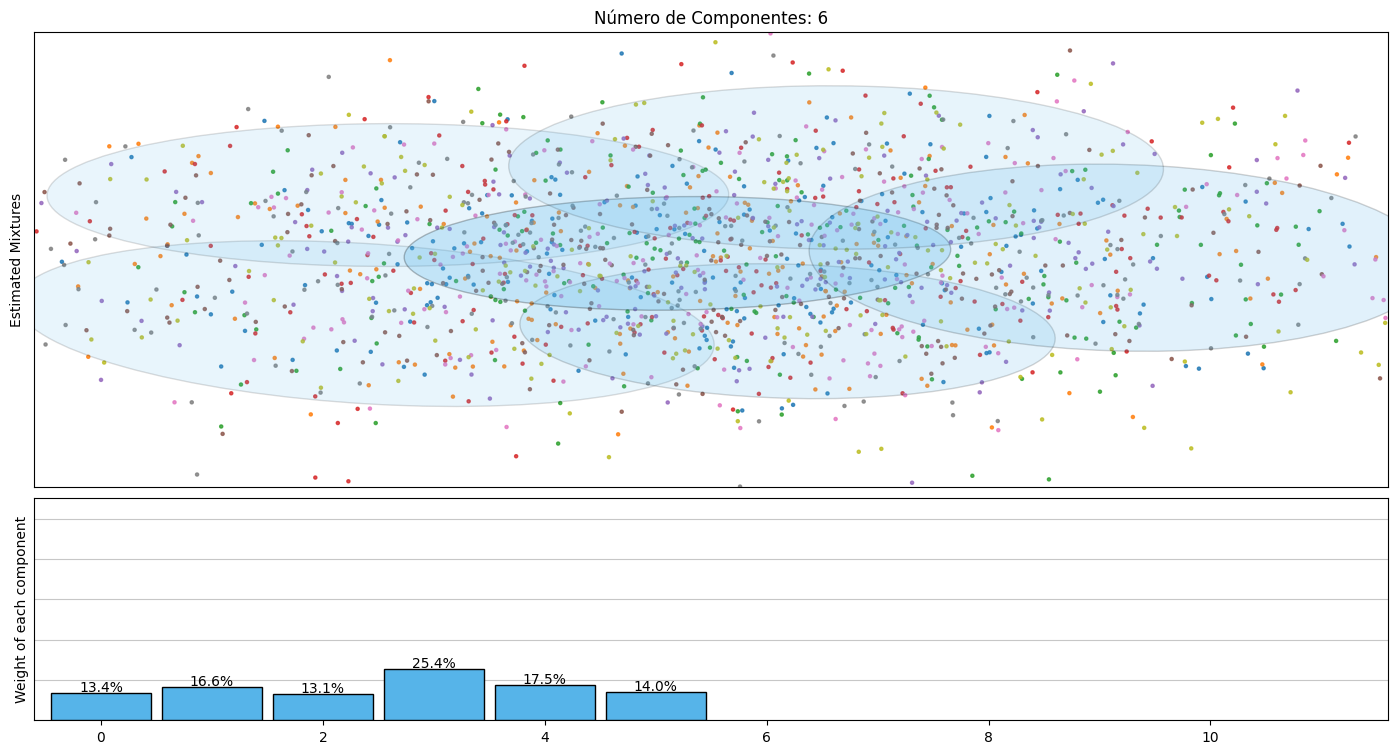

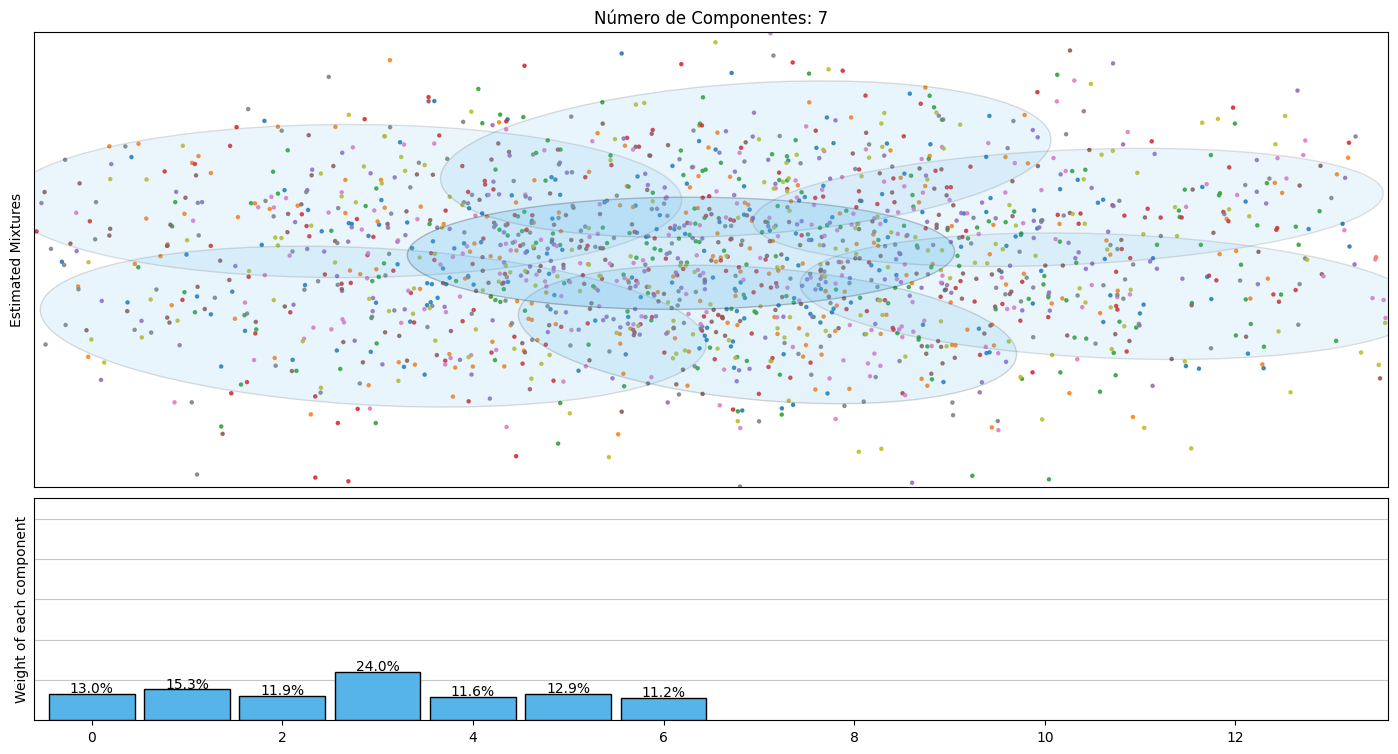

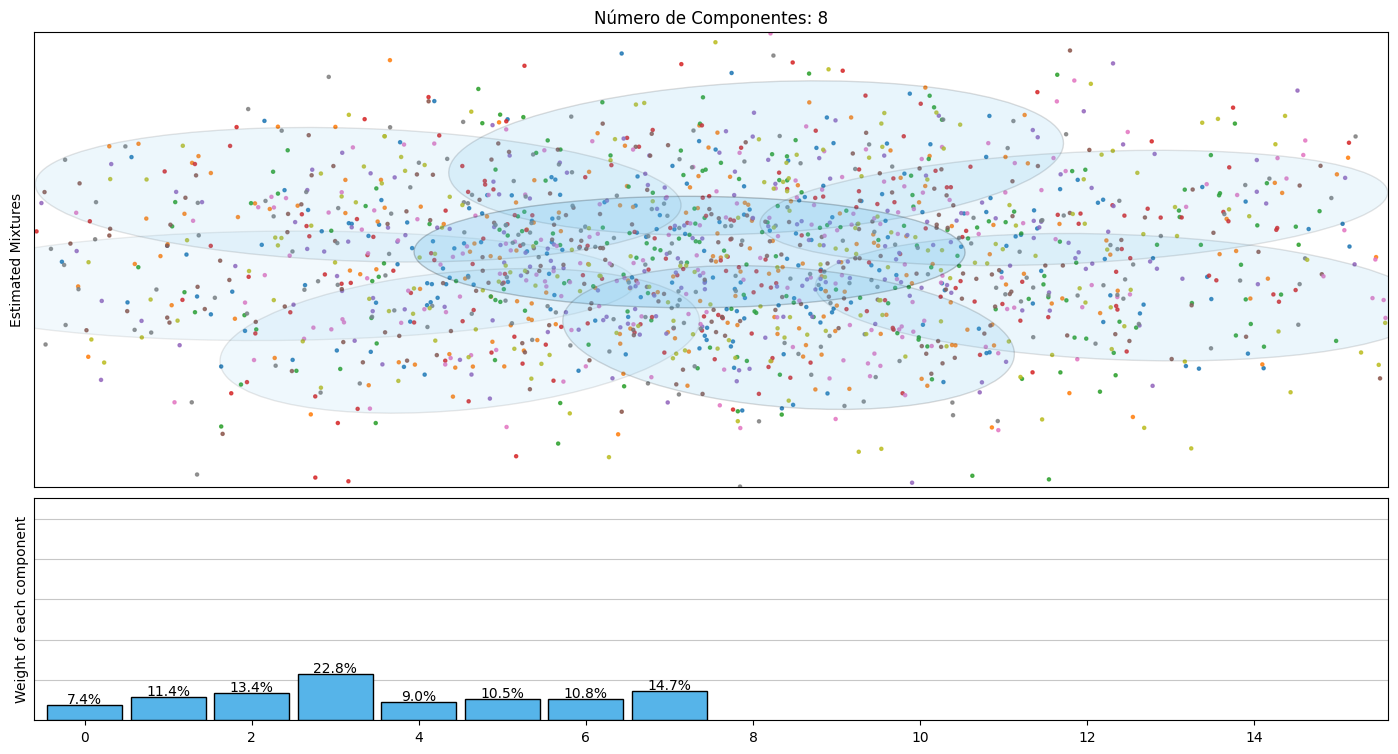

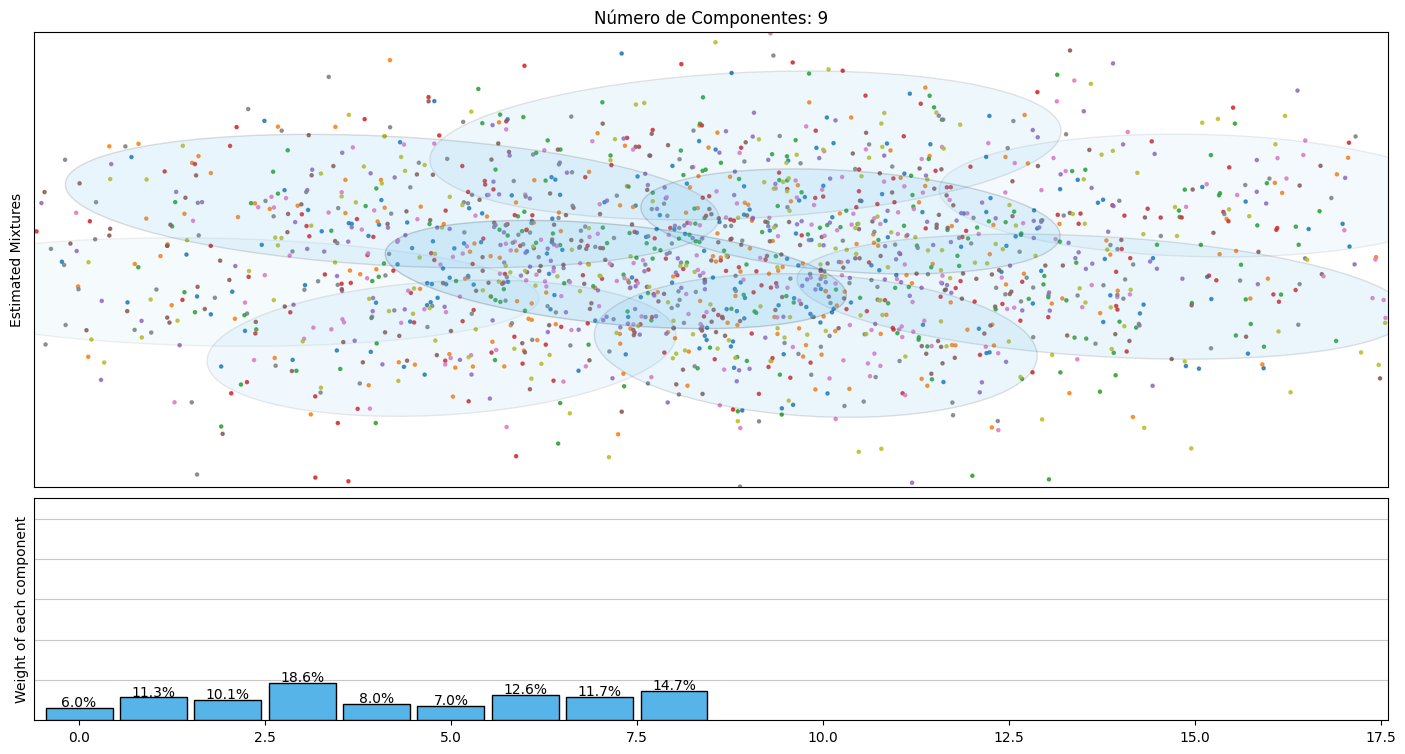

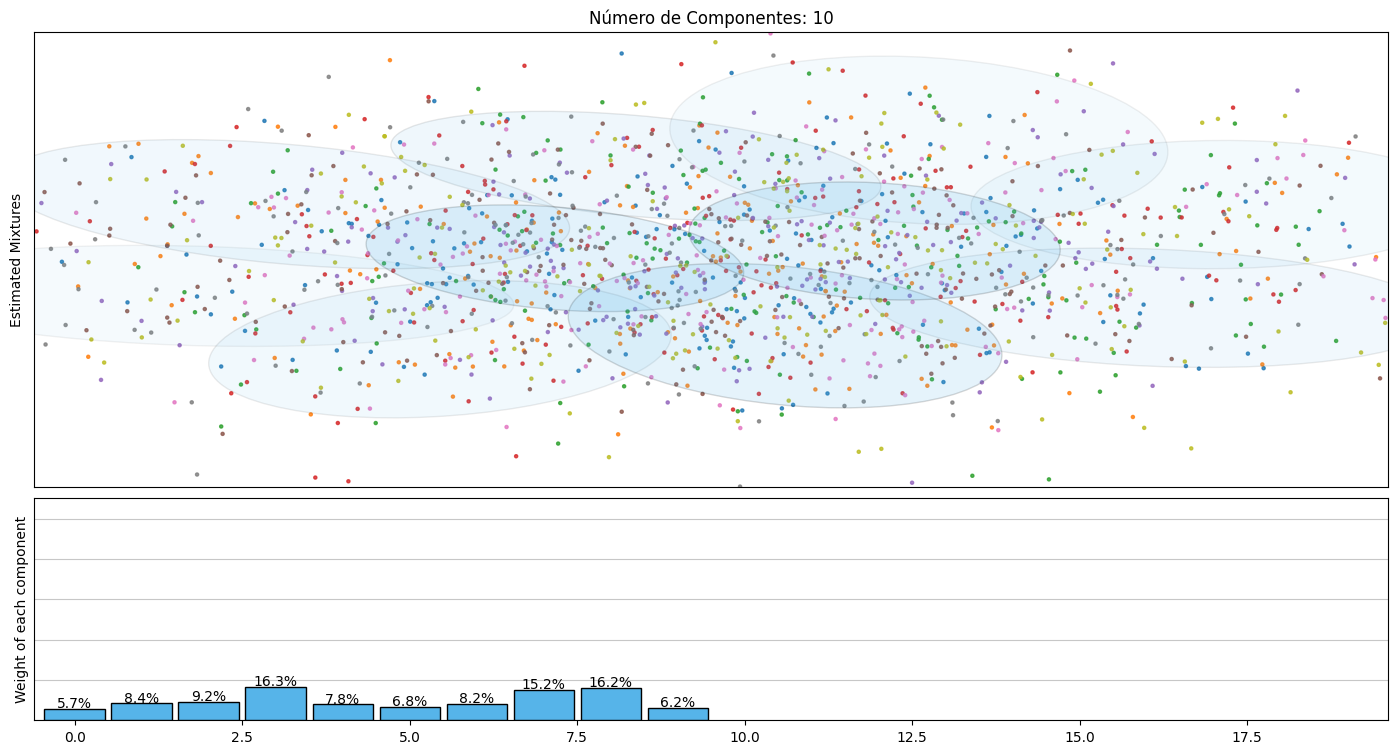

In [28]:
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1], angle=180 + angle, edgecolor="black"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor("#56B4E9")
        ax.add_artist(ell)

def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", color=colors[y], alpha=0.8)
    ax1.set_xlim(-2.0, 2.0)
    ax1.set_ylim(-3.0, 3.0)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_, estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction="out")
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(
            k,
            w,
            width=0.9,
            color="#56B4E9",
            zorder=3,
            align="center",
            edgecolor="black",
        )
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center")
    ax2.set_xlim(-0.6, 2 * n_components - 0.4)
    ax2.set_ylim(0.0, 1.1)
    ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax2.tick_params(axis="x", which="both", top=False)

    if plot_title:
        ax1.set_ylabel("Estimated Mixtures")
        ax2.set_ylabel("Weight of each component")

# Definir el rango de componentes
n_components_range = range(2, 11)

# Crear un color para cada cluster
colors = plt.cm.tab10(np.arange(n_components_range[-1]))

# Generar datos de ejemplo
rng = np.random.RandomState(42)
X = np.vstack([rng.multivariate_normal([0, 0], np.eye(2), 200) for _ in n_components_range])
y = np.concatenate([np.full(200, i, dtype=int) for i in range(len(n_components_range))])

# Graficar los resultados
for n_components in n_components_range:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(
        bottom=0.04, top=0.90, hspace=0.05, wspace=0.05, left=0.03, right=0.99
    )

    gs = gridspec.GridSpec(3, 1)
    estimator = GaussianMixture(n_components=n_components, random_state=42, max_iter=100)
    estimator.fit(X)
    
    plot_results(
        plt.subplot(gs[0:2, 0]),
        plt.subplot(gs[2, 0]),
        estimator,
        X,
        y,
        f'Número de Componentes: {n_components}',
        plot_title=True,
    )

plt.show()


Un Silhouette Score de 0.044 indica que los clusters identificados por el modelo Gaussian Mixture Model (GMM) tienen una cohesión interna muy baja y una separación entre clusters que no es clara. En términos prácticos:

Baja Cohesión: Los puntos dentro de los mismos clusters no están muy cerca unos de otros, lo que sugiere que los clusters no están bien definidos.

Mala Separación: Los clusters no están claramente separados entre sí. Esto podría indicar que los puntos de diferentes clusters se solapan o están muy cerca unos de otros.

### Análisis con Estado y Categoría

In [45]:
df_fraude['category_encoded'] = LabelEncoder().fit_transform(df_fraude['category'])
df_fraude['state_encoded'] = LabelEncoder().fit_transform(df_fraude['state'])


# Seleccionar columnas numéricas y las columnas categóricas codificadas
features = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'edad', 'zip', 'category_encoded', 'state_encoded']
X = df_fraude[features]

In [46]:
# Normalizar las caracteristicas 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [47]:
print(f"Forma de 'X_scaled': {X_scaled.shape}")

# Verifica si faltan columnas en 'features'
if X_scaled.shape[1] > len(features):
    extra_features = ['feature_9', 'feature_10']  # Nombres de las columnas adicionales
    features.extend(extra_features)
# Verificación de la forma de los datos

Forma de 'X_scaled': (555719, 10)


In [48]:
# Se entrena un modelo Gaussian Mixture Model (GMM) con el número óptimo de componentes determinado por BIC.
gmm = GaussianMixture(n_components=optimal_n_components, n_init=1, random_state=42)
gmm.fit(X_scaled)

GaussianMixture(n_components=9, random_state=42)

Se crea un DataFrame que incluye las características, las etiquetas de los clusters y una columna adicional para indicar si es fraude.

In [49]:
# Obtener las etiquetas de cluster
labels = gmm.predict(X_scaled)

# Crear un DataFrame con las características y las etiquetas de cluster
df_clusters = pd.DataFrame(X_scaled, columns=features)
df_clusters['Cluster'] = labels
df_clusters['is_fraud'] = df_fraude['is_fraud'].values
print(df_clusters.head())

        amt       lat      long  city_pop  merch_lat  merch_long      edad  \
0 -0.424463 -0.904377  0.677451  0.816521  -0.894145    0.657586  0.328762   
1 -0.252337  0.351182 -1.472454 -0.292685   0.178126   -1.436610 -0.933359   
2 -0.179353  0.420768  1.216667 -0.178853   0.383257    1.167640  0.156655   
3 -0.059605 -1.970539  0.685934 -0.111371  -1.909485    0.680717 -0.761251   
4 -0.422358  1.128092  0.380004 -0.289942   1.259139    0.316510  1.074561   

        zip  category_encoded  state_encoded  Cluster  is_fraud  
0 -0.731091          0.961683       0.937072        2         0  
1  1.309217          0.961683       1.220424        7         0  
2 -1.382695         -0.316151       0.512044        2         0  
3 -0.598119          0.706116      -1.258908        4         0  
4  0.029394          1.728384      -0.338013        7         0  


Evaluación del modelo

In [50]:
# Se calcula el coeficiente de silueta en una muestra aleatoria de 10,000 instancias para evaluar la calidad del clustering.

X_sample_small = shuffle(X_scaled, random_state=42)[:10000]
clusters_small = gmm.predict(X_sample_small)
sil_score_small = silhouette_score(X_sample_small, clusters_small)
print(f'Silhouette Score (small sample): {sil_score_small:.3f}')

Silhouette Score (small sample): 0.057


In [51]:
# Verifica el número de columnas en 'features' y 'X_sample_scaled'
print(f"Cantidad de características en 'features': {len(features)}")
print(f"Forma de 'X_sample_scaled': {X_sample_scaled.shape}")


Cantidad de características en 'features': 10
Forma de 'X_sample_scaled': (10000, 8)


La homogeneidad calculada y las visualizaciones proporcionan información valiosa sobre la agrupación de las transacciones y la detección de posibles fraudes en los datos.

Homogeneidad del clustering: 0.2828


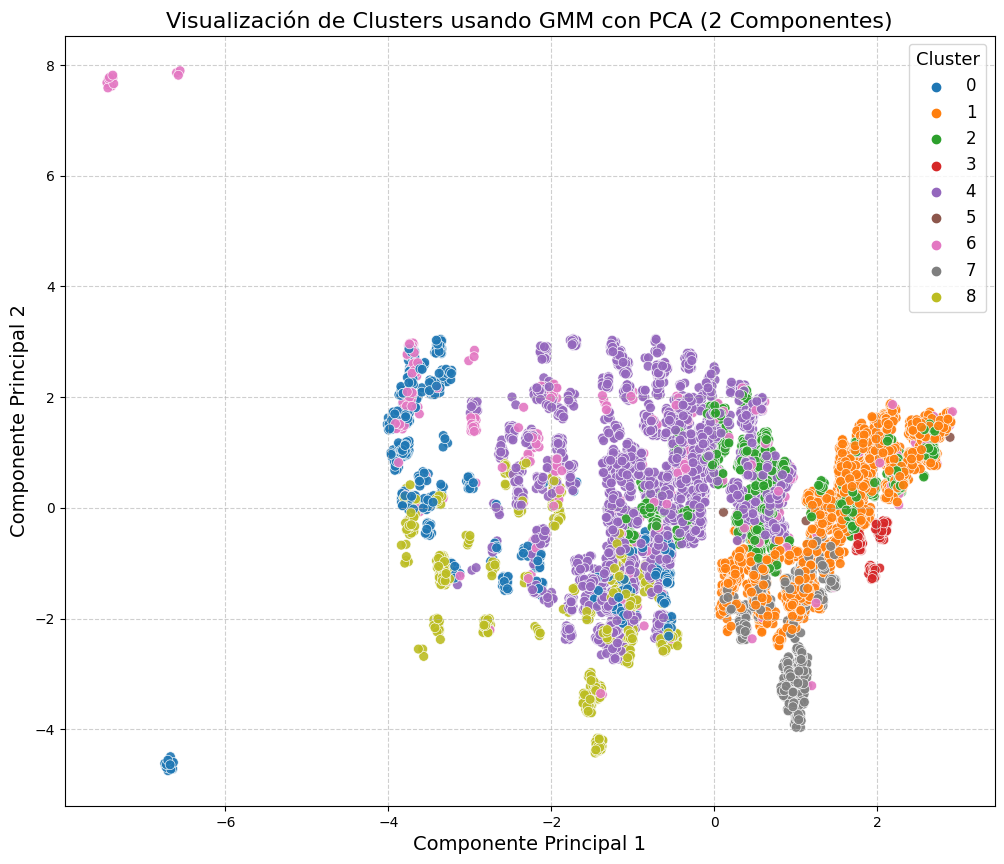

In [52]:
from sklearn.metrics import homogeneity_score

# Ajuste final del modelo GMM con el número óptimo de componentes
optimal_n_components = 9
gmm_final = GaussianMixture(n_components=optimal_n_components, random_state=42)
gmm_final.fit(X_sample_scaled)
clusters = gmm_final.predict(X_sample_scaled)

# Evaluar la homogeneidad del clustering
homogeneity = homogeneity_score(df_sample['is_fraud'], clusters)
print(f'Homogeneidad del clustering: {homogeneity:.4f}')

# Visualización de los clusters en 2D usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample_scaled)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='tab10', s=50, alpha=0.9, edgecolor='w', linewidth=0.5)
plt.title('Visualización de Clusters usando GMM con PCA (2 Componentes)', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=14)
plt.ylabel('Componente Principal 2', fontsize=14)
plt.legend(title='Cluster', fontsize=12, title_fontsize='13')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


El valor de homogeneidad que has obtenido, 0.2828, indica que el clustering realizado tiene una baja homogeneidad, lo que sugiere que los clusters formados no son completamente consistentes con respecto a la clase objetivo (is_fraud). En otras palabras, los puntos de datos dentro de un mismo cluster no pertenecen mayoritariamente a la misma clase. Si el fraude es un comportamiento raro y difícil de detectar, es posible que los clusters no se alineen bien con las clases de fraude y no fraude, lo que puede reflejar la naturaleza compleja y mixta de los datos. Un valor bajo de homogeneidad no necesariamente invalida el modelo, pero sugiere que deberías interpretar los resultados con cautela y considerar otras métricas complementarias (como el coeficiente de silueta o la completitud) para evaluar el desempeño del clustering.

### Coeficiente de Rand (Rand Index)

El Coeficiente de Rand mide la similitud entre dos particiones de un conjunto de datos. 

In [54]:
# Asumimos que 'true_labels' es una serie con las etiquetas verdaderas y 'labels' las etiquetas predichas
true_labels = df_fraude['is_fraud']  # Etiquetas verdaderas (o puedes usar otra columna si disponible)
rand_index = rand_score(true_labels, labels)

print(f'Coeficiente de Rand: {rand_index:.4f}')

Coeficiente de Rand: 0.2212


El Coeficiente de Rand mide la similitud entre la partición de los datos y las etiquetas verdaderas. Un valor de 0.2212 indica una similitud baja entre las etiquetas de los clusters y las etiquetas verdaderas. Esto sugiere que el modelo GMM no está capturando bien la estructura subyacente de los datos en relación con las etiquetas verdaderas.

### Completitud (Completeness)

La completitud mide la proporción de todos los puntos de datos en un cluster que están correctamente agrupados en el mismo cluster según las etiquetas verdaderas.

In [55]:
# Convertir las etiquetas a tipo entero si es necesario
true_labels = df_fraude['is_fraud'].astype(int)  # Asumiendo que 'is_fraud' es una columna con etiquetas verdaderas
completeness = completeness_score(true_labels, labels)

print(f'Completitud: {completeness:.4f}')

Completitud: 0.0035


La completitud mide qué tan bien los puntos de datos dentro de un cluster están agrupados en la misma clase según las etiquetas verdaderas. Un valor de 0.0035 es extremadamente bajo, esto indica una falta de capacidad del modelo para identificar correctamente las estructuras en los datos.

### Pureza (Purity)


La pureza mide la proporción de puntos de datos en un cluster que pertenecen a la clase dominante en ese cluster.

In [56]:
def purity_score(true_labels, clusters):
    # Crear una matriz de conteo
    cluster_labels = np.zeros_like(true_labels)
    
    for cluster in np.unique(clusters):
        mask = (clusters == cluster)
        most_common = np.bincount(true_labels[mask]).argmax()
        cluster_labels[mask] = most_common
        
    return np.mean(cluster_labels == true_labels)

true_labels = df_fraude['is_fraud'].astype(int)  # Etiquetas verdaderas
purity = purity_score(true_labels, labels)

print(f'Pureza: {purity:.4f}')

Pureza: 0.9961


Un valor de 0.9961 es muy alto, lo que indica que los clusters generados por el modelo son muy puros en términos de las etiquetas verdaderas. Esto sugiere que, aunque el modelo GMM agrupa correctamente los puntos dentro de los clusters, estos clusters pueden no reflejar bien las etiquetas verdaderas a nivel global.

### Validación Cruzada para Clustering

In [57]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

silhouette_scores = []

for train_index, test_index in kf.split(X_sample_scaled):
    X_train, X_test = X_sample_scaled[train_index], X_sample_scaled[test_index]
    
    gmm = GaussianMixture(n_components=optimal_n_components, random_state=42)
    gmm.fit(X_train)
    clusters = gmm.predict(X_test)
    
    if len(np.unique(clusters)) > 1:
        sil_score = silhouette_score(X_test, clusters)
        silhouette_scores.append(sil_score)

average_silhouette_score = np.mean(silhouette_scores)
print(f'Silhouette Score Promedio en Validación Cruzada: {average_silhouette_score:.4f}')


Silhouette Score Promedio en Validación Cruzada: 0.0248


Un valor de 0.0248 es muy bajo, indicando que los puntos están apenas agrupados dentro de sus propios clusters y que los clusters pueden solaparse. Esto sugiere que la separación entre los clusters no es clara y el modelo puede estar encontrando dificultades para diferenciar entre las diferentes agrupaciones en los datos.

# Conclusión

GMM parece ser un buen modelo, teniendo en cuenta que el conjunto de datos contiene 555719 filas y que solo utilizamos una muestra de 10000 (que es mas manejable para las pruebas y evaluaciones) es uno de los modelos que mejor se ajusta a los datos, per su baja homogeneidad y el silhouette bajo nos indica que el clustering podría no estar capturando bien la estructura subyacente relacionada con el fraude, en otras palabras, los clusters no están bien diferenciados en términos de la variable objetivo (fraude).

En el análisis podemos ver que los valores de AIC y BIC muestran la calidad del ajuste del modelo con diferentes números de componentes. El número óptimo de componentes se selecciona considerando el equilibrio entre la complejidad del modelo y su capacidad para ajustarse a los datos, por lo que se selecciona el número de componente óptimo en este caso el que minimiza el BIC (Bayesian Information Criterion) es 10, con un BIC de -691.96, lo que indica que el modelo con 10 componentes es el más parsimonioso y ajustado a los datos entre las opciones consideradas.

Con respecto a Silhouette score, el maxino es de 0.1252 y la muestra pequeña de 0.057. El Silhouette Score mide la cohesión y separación de los clusters formados. Un valor bajo indica que los clusters no están bien definidos. En este caso, el bajo Silhouette Score sugiere que los clusters generados no están claramente diferenciados ni bien definidos.

Por otro lado, la homogeneidad del Clustering de 0.2828, un valor bajo de homogeneidad indica que dentro de los clusters formados hay una mezcla significativa de las clases objetivo (fraude vs. no fraude). Esto es esperable en un problema de detección de fraudes, dado que el fraude es un evento raro y puede estar mezclado con muchas transacciones legítimas. Sin embargo, es una señal de que el clustering no está alineado perfectamente con las etiquetas de fraude.

El modelo GMM muestra una alta pureza, lo cual puede ser un indicativo de que los clusters formados tienen puntos similares dentro de cada uno. Sin embargo, la baja completitud y el bajo coeficiente de Rand sugieren que estos clusters no corresponden bien con las etiquetas verdaderas del dataset. Además, el bajo Silhouette Score indica que los clusters pueden no ser bien separados.